In [1]:
import PIL
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [2]:
# easily aligned tall skinny patch of random noise
column_dims = (1024, 256)
column_height, column_width = column_dims

palettes = {
    "Grayscale": ["#000000", "#555555", "#AAAAAA", "#DDDDDD", "#FFFFFF"],
    "Cool Tones": ["#001f3f", "#0074D9", "#7FDBFF", "#39CCCC", "#3D9970"],
    "Warm Tones": ["#85144b", "#FF4136", "#FF851B", "#FFDC00", "#3D9970"],
    "Earth Tones": ["#8B4513", "#6B8E23", "#F5F5DC", "#F0E68C", "#006400"],
    "Pastel": ["#FFB6C1", "#ADD8E6", "#90EE90", "#E6E6FA", "#FFDAB9"],
    "Monochromatic Blue": ["#001f3f", "#4169E1", "#87CEEB", "#ADD8E6", "#B0E0E6"],
    "Retro": ["#FFDB58", "#B7410E", "#808000", "#3EB489", "#F5F5DC"]
}

# Function to apply palette to random values
def apply_palette(values, palette):
    colormap = [mcolors.hex2color(palette[v]) for v in values.flatten()]
    colormap = np.array(colormap).reshape(values.shape + (3,))
    return colormap

values = np.random.randint(0, 5, column_dims)

column = apply_palette(values, palettes["Warm Tones"])

# # plot the column at full resolution
# fig, ax = plt.subplots(dpi=256)
# ax.imshow(column)
# ax.axis('off')
# plt.show()

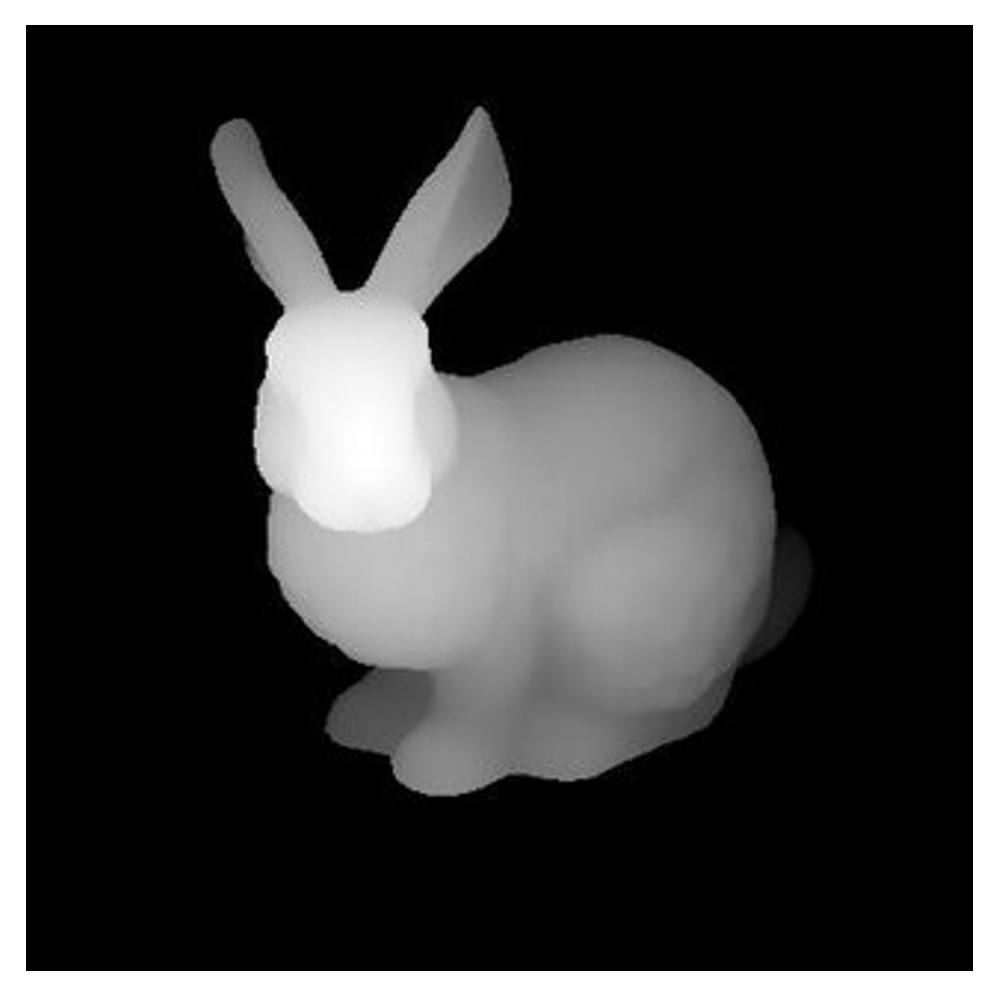

In [3]:
DEPTH_MAP = 'rabbit.jpg' # 'elephant.png'

img = PIL.Image.open(DEPTH_MAP)
img = img.resize((column_height, column_height)).convert('L')

depth = np.array(img)
depth = depth / 255.0

# plot the depth map
fig, ax = plt.subplots(dpi=256)
ax.imshow(depth, cmap='gray')
ax.axis('off')
plt.show()

In [4]:
SHIFT_RANGE = 0.3

output_values = np.zeros(depth.shape, dtype=int)
# write the noise to the first column of output
output_values = np.hstack((values, output_values))

for y in range(output_values.shape[0]):
    for x in range(output_values.shape[1]):
        depth_value = depth[y, x - column_width] # depth from 0 to 1
        
        if x < column_dims[1]:
            continue
        
        shift = column_width - (depth_value * SHIFT_RANGE * column_width)
        
        # shifted_x = max(0, min(column_dims[1] - 1, x - shift))
        shifted_x = x - shift
        
        interpolated_value = np.random.choice([output_values[y, int(np.floor(shifted_x))],
                                               output_values[y, int(np.ceil(shifted_x))]],
                                              p=[1 - (shifted_x % 1), shifted_x % 1])
        
        output_values[y, x] = interpolated_value
        


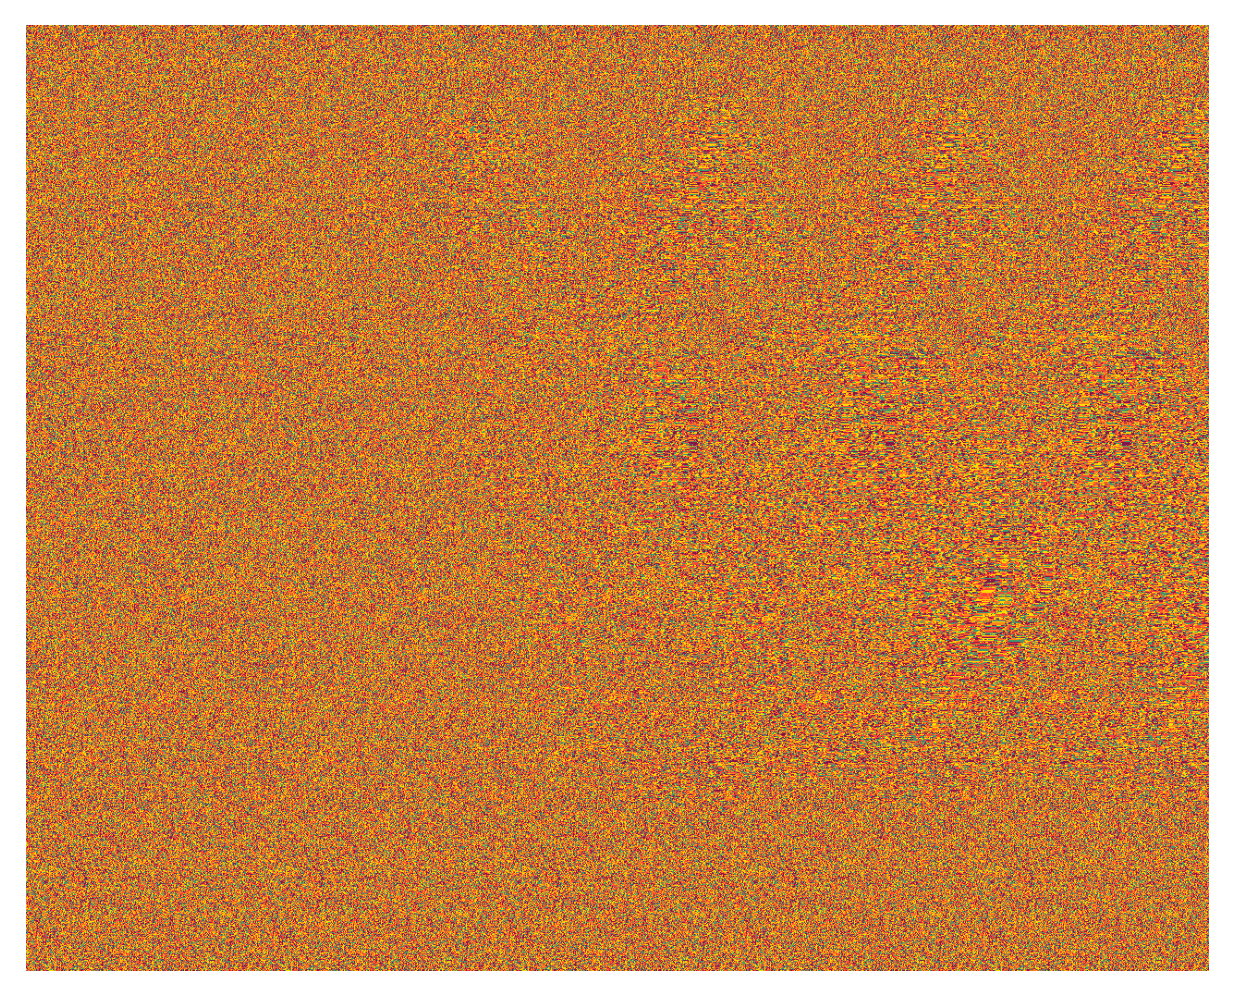

In [5]:
output = apply_palette(output_values, palettes["Warm Tones"])

fig, ax = plt.subplots(dpi=256)
ax.imshow(output)
ax.axis('off')
# fig.savefig('output.png', bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

In [6]:
# same as above but operating directly on column
output = np.zeros((*depth.shape, 3))


In [7]:
class Column:
    """
    Class providing the interface for a column of anything which may
    be used as the pattern for a magic eye image.
    """
    
    def __init__(self):
        pass
    
    def get_value(self, x, y):
        """Should get the value at the given coordinates.

        Args:
            x (float): The x-coordinate of the value to get, in the range [0, width)
            y (float): The y-coordinate of the value to get, in the range [0, height)
        """
        pass
    
    def height(self):
        return self.height
    
    def width(self):
        return self.width
    
    def get_pixels(self):
        """Get the values of the column as a 2D numpy array."""
        return np.array([[self.get_value(x, y) for x in range(self.width())] for y in range(self.height())])
    

class TransformedColumn(Column):
    """
    A column which is a transformation of another column.
    """
    
    def __init__(self, column, transform):
        self.column = column
        self.transform = transform
        self.height = column.height
        self.width = column.width
    
    def get_value(self, x, y):
        return self.column.get_value(*self.transform(x, y))
    
    
class DiscreteColumn(Column):
    """
    A column which has discrete values at each pixel.
    """
    
    def __init__(self, values):
        self.values = values
        self.height, self.width = values.shape
    
    def get_value(self, x, y):
        return self.values[int(y), int(x)]